In [1]:
# import packages

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import ipywidgets as widgets
import warnings

# Suppress runtime warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [2]:
# salinity function 
def fs_salinity(s_br_array):
    """
    Calculate the salinity function f_s as a function of salinity.
    The equation used is f_s = exp(-((2.16 - a - b) ** 2)), where:
    - a = 8.3 * 10 ** (-5) * s ** 2.11
    - b = 0.55 * log(s)
    - s is the salinity in g kg^-1
    
    Parameters:
    s_min (float): Minimum salinity in g kg^-1.
    s_max (float): Maximum salinity in g kg^-1.

    Returns:
    numpy.ndarray: Salinity function f
    """
    a_br = 8.3 * 10 ** (-5) * np.power(s_br_array, 2.11)
    b_br = 0.55 * np.log(s_br_array)
    f_s = np.exp(-((2.16 - a_br - b_br) ** 2))

    return f_s

# temperature function
def ft_temperature(t_c_array):
    """
    Model temperature function f_t as an exponential function of temperature.

    Parameters:
    t_min (float): Minimum temperature in degrees Celsius.
    t_max (float): Maximum temperature in degrees Celsius.

    Returns:
    numpy.ndarray: Temperature function f_t
    
    """
    r_g = 0.0633
    f_t = np.exp(r_g * t_c_array)

    return f_t

# nutrient function
def ln_nutrient(c_n_array, k:float):
    """A function to calculate the nutrient function as a function of nutrient concentration.
    The equation used is l_n = c_n / (k_n + c_n), where:
    - c_n is the nutrient concentration in mmol m^-3
    - k_n = 1.6 micro M
    - k_si = 3.9 micro M
    - k_p = 0.24 micro M
    - l_n = c_n / (k_n + c_n)

    Parameters:
    c_min (float): Minimum nutrient concentration in mmol m^-3.
    c_max (float): Maximum nutrient concentration in mmol m^-3.
    k (float): Nutrient concentration in mmol m^-3.

    Returns:
    numpy.ndarray: Nutrient function l_n
    """
    # c in mmol m-3
    k_n = 1.6  # in micrometers
    k_si = 3.9  # in micrometers
    k_p = 0.24  # in micrometers
    l_n = c_n_array / (k_n + c_n_array)
    l_si = c_n_array / (k_si + c_n_array)
    l_p = c_n_array / (k_p + c_n_array)
    # nutrient for k
    l_random = c_n_array / (k + c_n_array)

    return l_random

# light function

# PAR function
def photosynthetic_active_radiation(z, kappa=1.5, i_0=0.17, alpha=1e-4, F_s_w=5):
    """
    Calculate the Photosynthetically Active Radiation (PAR) at a given depth in ice.
    The equation used is PAR = 4.91 * I(z), where I(z) = I_0 * exp(-kappa * z).
    The constants used are:
    - kappa = 1.5 m^-1
    - i_0 = 0.17 for snow free ice and =0 for snow covered ice
    - alpha = 1e-4 g C (g Chla h micro E m-2 s-1)^-1
    - F_s_w = 5 W m^-2 incoming solar irradiance 1361 https://www.google.com/url?sa=t&source=web&rct=j&opi=89978449&url=https://en.wikipedia.org/wiki/Solar_irradiance&ved=2ahUKEwiL5Z2Qw_6JAxV30wIHHWQXD4AQFnoECCEQAw&usg=AOvVaw3cpr_oSPFpcgj7Ny50mW76
    - I_0 = i_0 * (1 - alpha) * F_s_w
    - PAR = 4.91 * I(z)

    Parameters:
    - z (float): Depth in ice (m).
    - kappa (float): Attenuation coefficient (m^-1).
    - i_0 (float): Incident solar radiation (W m^-2).
    - alpha (float): Absorption coefficient (g C (g Chla h micro E m-2 s-1)^-1).
    - F_s_w (float): Incoming solar irradiance (W m^-2).

    Returns:
    - float: PAR at the given depth in ice (W m^-2).
    """
    I_0 = i_0 * (1 - alpha) * F_s_w
    I_array = I_0 * np.exp(-kappa * z)  # z is the depth in ice
    PAR = 4.91 * I_array  # in W m-2

    return PAR

# chlorophyll to carbon ratio function
def cholorophyl_to_C_ratio_par(PAR, ln, E=0.5, r_chl_c_max=0.05, r_chl_c_min=0.01):
    """
    Calculate the chlorophyll to carbon ratio r_chl_c_par as a function of depth in ice.
    The equation used is r_chl_c_par = r_chl_c_max - (r_chl_c_max - r_chl_c_min) * min(PAR / E, 1) * ln, where:
    - r_chl_c_max = 0.05
    - r_chl_c_min = 0.01
    - PAR = 4.91 * I(z)
    - E = 0.5 in micro E m-2 s-1
    - ln = c_n / (k_n + c_n)

    Parameters:
    r_chl_c_max (float): Maximum chlorophyll to carbon ratio.
    r_chl_c_min (float): Minimum chlorophyll to carbon ratio.
    PAR (float): Photosynthetically Active Radiation at the given depth in ice (W m^-2).
    E (float): Energy (W m^-2).
    ln (float): Nutrient function l_n.

    Returns:
    float: Chlorophyll to carbon ratio r_chl_c_par at the given depth in ice.
    """

    return r_chl_c_max - (r_chl_c_max - r_chl_c_min) * np.min([np.min(PAR / E),1]) * ln

# maximum photosynthesis rate function
def Photosynthesis_rate_maximum_light(mu_m, fs, ft, ln, r_chl_c_par):
    """
    Calculate the maximum photosynthesis rate P_m as a function of depth in ice.
    The equation used is P_m = mu_m * fs * ft * ln / r_chl_c_par, where:
    - mu_m = 2e-5 in s^-1
    - fs = exp(-((2.16 - a - b) ** 2))
    - ft = exp(r_g * T_c)
    - ln = c_n / (k_n + c_n)
    - r_chl_c_par = r_chl_c_max - (r_chl_c_max - r_chl_c_min) * min(PAR / E, 1) * ln

    Parameters:
    mu_m (float): Maximum photosynthesis rate in s^-1.
    fs (numpy.ndarray): Salinity function f_s.
    ft (numpy.ndarray): Temperature function f_t.
    ln (numpy.ndarray): Nutrient function l_n.
    r_chl_c_par (numpy.ndarray): Chlorophyll to carbon ratio.

    Returns:
    numpy.ndarray: Maximum photosynthesis rate P_m at the given depth in ice.
    """
    return mu_m * fs * ft * ln / r_chl_c_par

def Ek_light(Photosynthesis_rate, alpha):
    """ 
    Calculate the light limitation Ek as a function of depth in ice.
    The equation used is Ek = P_m / alpha, where:
    - P_m = mu_m * fs * ft * ln / r_chl_c_par
    - mu_m = 2e-5 in s^-1
    - E = 0.5 in micro E m-2 s-1
    - alpha = 1e-4 in g C (g Chla h micro E m-2 s-1)-1
    - r_chl_c_max = 0.05
    - r_chl_c_min = 0.01
    - ln = c_n / (k_n + c_n)
    - fs = exp(-((2.16 - a - b) ** 2))
    - ft = exp(r_g * T_c)
    - r_chl_c_par = r_chl_c_max - (r_chl_c_max - r_chl_c_min) * min(PAR / E, 1) * ln
    - P_m = mu_m * fs * ft * ln / r_chl_c_par
    - E_k = P_m / alpha

    Parameters:
    - Photosynthesis_rate (float): Maximum photosynthesis rate in s^-1.
    - alpha (float): in g C (g Chla h micro E m-2 s-1)-1

    Returns:
    - float: Light limitation Ek at the given depth in ice.
    """

    return Photosynthesis_rate / alpha

def Ek_light_tanh(PAR_arr:np.array, Ek_arr:np.array):
    """ 
    
    Calculate the light limitation Ek as a function of depth in ice.
    The equation used is Ek = P_m / alpha, where:
    - P_m = mu_m * fs * ft * ln / r_chl_c_par
    - mu_m = 2e-5 in s^-1
    - E = 0.5 in micro E m-2 s-1
    - alpha = 1e-4 in g C (g Chla h micro E m-2 s-1)-1
    - r_chl_c_max = 0.05
    - r_chl_c_min = 0.01
    - ln = c_n / (k_n + c_n)
    - fs = exp(-((2.16 - a - b) ** 2))
    - ft = exp(r_g * T_c)
    - r_chl_c_par = r_chl_c_max - (r_chl_c_max - r_chl_c_min) * min(PAR / E, 1) * ln
    - P_m = mu_m * fs * ft * ln / r_chl_c_par
    - E_k = P_m / alpha

    Parameters:
    - PAR_arr (np.array): PAR at the given depth in ice.
    - Ek_arr (np.array): Light limitation Ek at the given depth in ice.

    Returns:
    - np.array: Light limitation Ek at the given depth in ice.
    
    """

    return np.tanh(PAR_arr / Ek_arr)

# photosynthetic rate function
def photosynthetic_rate(max_mu, fs, ft, ln, lpar):
    """
    Calculate the photosynthetic rate as a function of depth in ice.
    The equation used is mu = max_mu * fs * ft * ln * lpar, where:
    - max_mu = 2e-5 in s^-1
    - fs = exp(-((2.16 - a - b) ** 2)), where:
        - a = 8.3 * 10 ** (-5) * s ** 2.11
        - b = 0.55 * log(s)
        - s is the salinity in g kg^-1
    - ft = exp(r_g * T_c)
    - r_g = 0.0633
    - T_c is the temperature in degrees Celsius
    - ln = c_n / (k_n + c_n)
    - lpar = tanh(PAR / Ek)
    - Ek = P_m / alpha
    - P_m = mu_m * fs * ft * ln / r_chl_c_par
    - r_chl_c_par = r_chl_c_max - (r_chl_c_max - r_chl_c_min) * min(PAR / E, 1) * ln
    - E = 0.5 in micro E m-2 s^-1
    - alpha = 1e-4 in g C (g Chla h micro E m-2 s^-1)-1
    - mu = max_mu * fs * ft * ln * lpar

    Parameters:
    - s_min (float): Minimum salinity in g kg^-1.
    - s_max (float): Maximum salinity in g kg^-1.
    - t_min (float): Minimum temperature in degrees Celsius.
    - t_max (float): Maximum temperature in degrees Celsius.
    - c_min (float): Minimum nutrient concentration in mmol m^-3.
    - c_max (float): Maximum nutrient concentration in mmol m^-3.
    - k (float): Nutrient concentration in mmol m^-3.
    - z_min (float): Minimum depth in ice in m.
    - z_max (float): Maximum depth in ice in m.
    - alpha (float): in g C (g Chla h micro E m^-2 s^-1)-1
    - index (int): index of the depth in ice.

    Returns:
    - float: Photosynthetic rate at the given depth in ice.
    """
    return max_mu * fs * ft * ln * lpar

# f_s * f_t function
def fs_ft(f_s, f_t):
    """
    Calculate the temperature x salinity function f_s * f_t.
    The equation used is f_s * f_t = f_t * f_s, where:
    - f_t = exp(r_g * T_c)
    - f_s = exp(-((2.16 - a - b) ** 2)), where:
        - a = 8.3 * 10 ** (-5) * s ** 2.11
        - b = 0.55 * log(s)
        - s is the salinity in g kg^-1
    - r_g = 0.0633

    Parameters:
    t_min (float): Minimum temperature in degrees Celsius.

    Returns:
    numpy.ndarray: Temperature x salinity function f_s * f_t
    """
    return f_t * f_s

def fs_ft_ln(f_s, f_t, l_n):
    """
    Calculate the salinity x temperature x nutrient function f_s * f_t * l_n.
    The equation used is f_s * f_t * l_n = f_s * f_t * l_n, where:
    - f_s = exp(-((2.16 - a - b) ** 2)), where:
        - a = 8.3 * 10 ** (-5) * s ** 2.11
        - b = 0.55 * log(s)
        - s is the salinity in g kg^-1

    - f_t = exp(r_g * T_c)
    - r_g = 0.0633
    - T_c is the temperature in degrees Celsius

    - l_n = c_n / (k_n + c_n), where:
        - c_n is the nutrient concentration in mmol m^-3
        - k_n = 1.6 micrometers

    Parameters:
    s_min (float): Minimum salinity in g kg^-1. 
    s_max (float): Maximum salinity in g kg^-1.
    t_min (float): Minimum temperature in degrees Celsius.
    t_max (float): Maximum temperature in degrees Celsius.
    c_min (float): Minimum nutrient concentration in mmol m^-3.
    c_max (float): Maximum nutrient concentration in mmol m^-3.
    k (float): Nutrient concentration in mmol m^-3.

    Returns:
    numpy.ndarray: Salinity x temperature x nutrient function f_s * f_t * l_n
    """

    return f_s * f_t * l_n

In [3]:
def model_algae_processes(s_br_array, t_c_array, c_n_array, z_array, k=1.6, mu_m=2e-5, alpha=1e-4, r_chl_c_max=0.05, r_chl_c_min=0.01, i_0=0.17, E=0.5, kappa=1.5, F_s_w=5):
    """ 
    Model the algae processes in sea ice.
    
    Parameters:
    - s_br_array (np.array): Salinity in g kg^-1.
    - t_c_array (np.array): Temperature in degrees Celsius.
    - c_n_array (np.array): Nutrient concentration in mmol m^-3.
    - z_array (np.array): Depth in ice in m.
    - k (float): half saturation constant in micro M = mmol m^-3.
    - mu_m (float): Maximum photosynthesis rate in s^-1.
    - alpha (float): Absorption coefficient in g C (g Chla h micro E m-2 s-1)^-1.
    - r_chl_c_max (float): Maximum chlorophyll to carbon ratio.
    - r_chl_c_min (float): Minimum chlorophyll to carbon ratio.
    - i_0 (float): Incident solar radiation in W m^-2.
    - E (float): Energy in W m^-2.
    - kappa (float): Attenuation coefficient in m^-1.
    - F_s_w (float): Incoming solar irradiance in W m^-2.

    Returns:
    - np.array: Photosynthetic rate at the given depth in ice.
    """
    # field functions
    salinity_function = fs_salinity(s_br_array)
    temperature_function = ft_temperature(t_c_array)
    nutrient_function = ln_nutrient(c_n_array, k)

    # light function
    PAR = photosynthetic_active_radiation(z_array, kappa, i_0, alpha, F_s_w)
    r_chl_c_par = cholorophyl_to_C_ratio_par(PAR, nutrient_function)
    P_m = Photosynthesis_rate_maximum_light(mu_m, salinity_function, temperature_function, nutrient_function, r_chl_c_par)
    Ek = Ek_light(P_m, alpha)
    l_PAR = Ek_light_tanh(PAR, Ek)

    # photosynthetic rate
    mu = photosynthetic_rate(mu_m, salinity_function, temperature_function, nutrient_function, l_PAR)

    return mu


In [4]:
# temperature degrees Celsius
temperature_list = np.linspace(-10, 1, 100)
# salinity g/kg = ppt
salinity_list = np.ones(100) * 34.0
# mmol/m3 using ode data
nutrient_list = np.ones(100) * 0.5
depth_list = np.linspace(0, 1, 100)

mu = model_algae_processes(salinity_list, temperature_list, nutrient_list, depth_list, k=3.9)

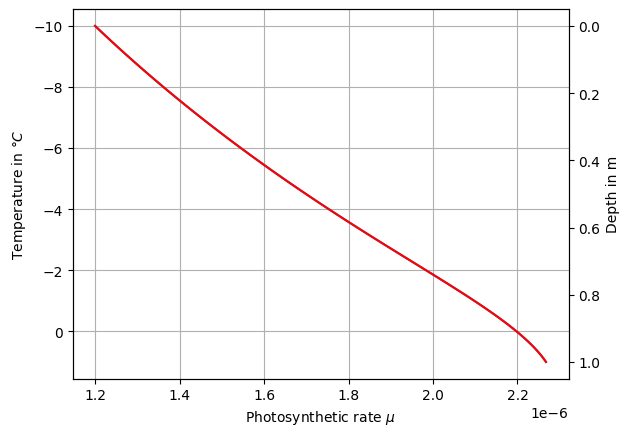

In [5]:
plt.grid()
plt.plot(mu, temperature_list)
plt.xlabel(r'Photosynthetic rate $\mu$')
plt.ylabel(r'Temperature in $\degree C$')
plt.gca().invert_yaxis()
ax2 = plt.gca().twinx()
ax2.plot(mu, depth_list, color='r')
ax2.set_ylabel(r'Depth in m')
ax2.invert_yaxis()


## ODE system of equations

In [6]:
# BUG: update mu for new cn values
# TODO: find initial values of cc and cn mmol C(or N) m-3
# TODO: update for everytime step with salinity-model

time = np.linspace(0, 100, 100)
cc = 0.01  # TODO: find value - one algal group concentration in mmol m-3 in ice and 0.05 in sea water
cn = 19.9  # nutrient concentration in mmol m-3 as per Vancoppenoelle et al. 2010 of dissolved silica (DSi) in the ice and 51.25 in sea water
f = 1  # nutrient conservation
lambda_ = 0.15 # carbon loss rate day-1
dt = 0.01  # random time step
t = 0  # initial time
cc_arr, cn_arr = [], []

mu = model_algae_processes(salinity_list, temperature_list, nutrient_list, depth_list, k=3.9)

while t < 100:
    cc_tp1 = cc + dt*(mu - lambda_)*cc
    cn_tp1 = cn + dt*(-mu + f*lambda_)*cc
    cc_arr.append(cc_tp1)
    cn_arr.append(cn_tp1)
    mu = model_algae_processes(salinity_list, temperature_list, cn_tp1, depth_list, k=3.9)
    t = t + dt
    cc = cc_tp1
    cn = cn_tp1

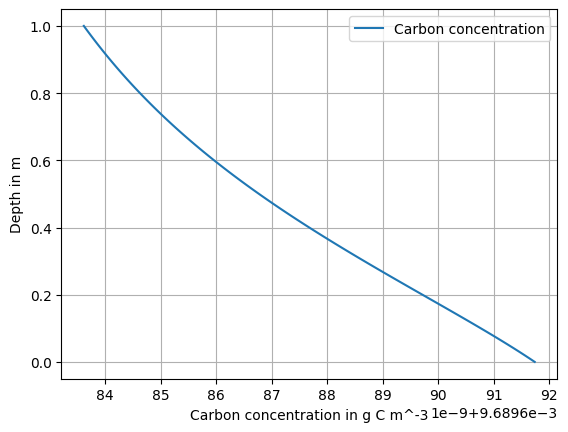

In [7]:
t_index = 50
plt.grid()
plt.plot(cc_arr[20], depth_list,  label='Carbon concentration')
#plt.plot(cc_arr[11], depth_list, label='Nutrient concentration')
plt.ylabel('Depth in m')
plt.xlabel('Carbon concentration in g C m^-3')
plt.legend()

In [8]:
cc_arr = np.array(cc_arr)
cn_arr  = np.array(cn_arr)


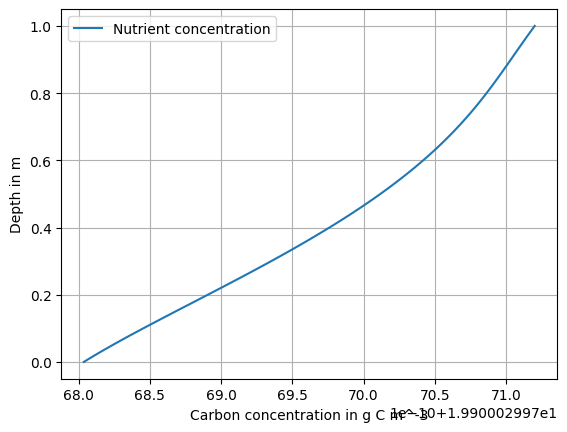

In [9]:
t_index = 1
plt.grid()
plt.plot(cn_arr[t_index], depth_list, label='Nutrient concentration')
plt.ylabel('Depth in m')
plt.xlabel('Carbon concentration in g C m^-3')
plt.legend()

In [10]:
def update_algal_growth(t_index, d_index):
    cn_by_cc = np.divide(cn_arr[int(t_index)],cc_arr[int(t_index)])
    fig, axs = plt.subplots(2, 2, figsize=(16, 10))
    for ax in axs.flat:
        ax.grid(True)
    ax1, ax2, ax3, ax4 = axs[0,0], axs[0,1], axs[1,0], axs[1,1] 
    (line1,) = ax1.plot(cc_arr[int(t_index)], depth_list,  label='Carbon concentration')
    (line2,) = ax2.plot(np.divide(cn_arr[int(t_index)],cc_arr[int(t_index)]), depth_list, label='Nutrient concentration')
    (line3,) = ax3.plot(np.arange(0,100,dt), cc_arr.T[int(d_index)], label='Carbon concentration')
    (line4,) = ax4.plot(np.arange(0,100,dt), cn_arr.T[int(d_index)], label='Nutrient concentration')
    ax1.set_ylabel('Depth in m')
    ax1.set_xlabel('Carbon concentration in g C m^-3')
    ax1.legend()
    ax1.invert_yaxis()
    ax2.set_ylabel('Depth in m')
    ax2.set_xlabel('Nutrient concentration in mmol m^-3')
    ax2.legend()
    ax2.invert_yaxis()
    ax3.set_xlabel('Time in days')
    ax3.set_ylabel('Carbon concentration in g C m^-3')
    ax3.legend()
    ax4.set_xlabel('Time in days')
    ax4.set_ylabel('Nutrient concentration in mmol m^-3')
    ax4.legend()
    # adjust the main plot to make room for the sliders
    fig.subplots_adjust(left=0.25, bottom=0.25)
    # The function to be called anytime a slider's value changes
    # Create the figure and the line that we will manipulate
    line1.set_xdata(cc_arr[int(t_index)])
    line2.set_xdata(np.divide(cn_arr[int(t_index)],cc_arr[int(t_index)]))
    line3.set_ydata(cc_arr.T[int(d_index)])
    line4.set_ydata(cn_arr.T[int(d_index)])
    fig.canvas.draw_idle()

In [11]:
# ui widgets
# salinity min and max
init_t = 1
init_depth = 1
t_widget = widgets.FloatSlider(
    value=init_t, min=0, max=100, step=1, description="time in days"
)
d_widget = widgets.FloatSlider(
    value=0, min=0, max=100, step=1, description="depth index"
)
# reset
reset_button_time = widgets.Button(description="Reset")

def reset_time(event):
    # salinity
    t_widget.value = init_t
    d_widget.value = init_depth

reset_button_time.on_click(reset_time)

interactive_plot_time = widgets.interact(
    update_algal_growth,
    t_index=t_widget,
    d_index=d_widget
)

# display(fig.canvas)
display(interactive_plot_time, reset_button_time)

interactive(children=(FloatSlider(value=1.0, description='time in days', step=1.0), FloatSlider(value=0.0, des…

<function __main__.update_algal_growth(t_index, d_index)>

Button(description='Reset', style=ButtonStyle())

## Tracer transport: single component (thermodynamic+bio routine can be found on: https://forge.ipsl.jussieu.fr/lim1d/browser/tags/LIM1D_v3.20/SOURCES/source_3.20/ice_th.f)

Tracers considered: dSi (dissolved silica) + Chl_a (bulk concentration of chlorophyll a)

initial and boundary values:
- dSi: 
    initial ice concentration: 19.90
    initial water concentration: 51.25

Chl_a_bulk = C_bulk_tracer x r_chl_c x c_molar_carbon (https://forge.ipsl.jussieu.fr/lim1d/browser/tags/LIM1D_v3.20/SOURCES/source_3.20/ice_bio_ini.f)

where,

C_bulk_tracer = bulk concentration of tracers from transport equation

r_chl_c = Chl:C ratio

c_molar_carbon = 12

for more information on the initial values of other tracer follow the link: https://forge.ipsl.jussieu.fr/lim1d/browser/trunk/INPUT/ISPOL/source_3.20/tracer.param

albedo = https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2017jc012828